# Introduction


Moscow now boasts for high development and growing rates. The city has been an attraction of people, recourses and finance for many years so far. The development of Moscow economy on the one side and the growing number of people living there on another side makes effective urban planning and elaborate policy establishment of high importance. There is a tendency that when the economy develops people are more and more engaged in recreation and sports activities. For the developed economy people and their quality of life become the central point of consideration of many policymakers along with businessmen to provide better services and cover the whole range of possible outdoor activities. Moscow neighborhoods are heterogeneous for historical reasons. There are different parts of the city in respect of their number of population, services, cost of living, etc. In any parts of the city there are a lot of outdoor sport activity objects while in the other just a few. So there may be different ratios between supply and demand of the sport services and objects. Understanding of these ratios may be helpful for local government and business as well. But it is highly important to mention that every area of the city is singular so it may be not practical to develop research in every neighborhood. Besides, when dealing with neighborhoods one by one the whole picture is lost. The better idea is to look at the whole Moscow but taking into consideration differences of neighborhood. So we need to divide areas in Moscow to groups according to their similarity. These groups may be studied further. This approach may reduce time and effort when dealing towards the decision of the creation of new sport objects for people or closing the operating ones. In this practical research Moscow areas are analyzed and clustered in relation to the presence of recreation sport object. Having done this analysis all neighborhoods of Moscow will be divided into groups using statistical clustering approach. So it may be helpful for business expansion and government policy making.

# Data

Foursquare data for coordinates and venues is used. Moreover, Wikipedia data for Moscow areas with population and social characteristics is utilized.

In [ ]:
# The code was removed by Watson Studio for sharing.

In [8]:
import numpy as np # library to handle data in a vectorized manner
!pip install geocoder
import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
!pip install folium
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
!pip install lxml
import folium # map rendering library

print("Libraries imported.")

Libraries imported.


In [9]:
%%capture 
#let's import and install required python libraries
!pip install BeautifulSoup4; #for dealing with XML and HTML
!pip install lxml
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [8]:
#let's get the list of Moscow districts and neighbourhoods
response = requests.get("https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%80%D0%B0%D0%B9%D0%BE%D0%BD%D0%BE%D0%B2_%D0%B8_%D0%BF%D0%BE%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B").text
soup = BeautifulSoup(response, 'lxml')

In [9]:

### we will delete columns that we are not inrested in
moscow_table = soup.find('table', {'class':'standard sortable'})
df = pd.read_html(str(moscow_table))[0]
headers = ['Num','Flag','Moto','Borough', 'Neighbourhood','Okrug','Square_KM2','Population','PopDensity_KM2','RE','REonPerson']
df.columns = headers
#drop extra columns that we will not use
df.drop(columns=['Num','Flag','Moto','Borough','Square_KM2','RE','REonPerson'], inplace = True)
#normalize data in columns
df.replace(to_replace=r'^↗|↘', value='', regex=True, inplace = True)
df.head(2)

,Neighbourhood,Okrug,Population,PopDensity_KM2
0,Академический,ЮЗАО,110 038,18874.44
1,Алексеевский,СВАО,80 634,15242.72


In [8]:

#leave only central okrugs (drop all rows where Okrug in ('ТАО', 'НАО', 'ЗелАО'))

df = df[~df['Okrug'].isin(['ТАО','НАО','ЗелАО'])]
#check that everything is fine
df['Okrug'].unique()

array(['ЮЗАО', 'СВАО', 'ЦАО', 'САО', 'ЮАО', 'ВАО', 'ЗАО', 'ЮВАО', 'СЗАО'],
      dtype=object)

In [9]:
%%capture
#1. Install Nominatim
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

In [10]:
#2. Enrich the dataset with an artificial field wich will contain joint address sufficient to get coordinates from Nominatim
df['address'] = df['Neighbourhood']+', ' + df['Okrug']

#3. Enrich the dataset with longtitude and latitide coordinates
geolocator = Nominatim(user_agent="foursquare_agent")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df['location'] = df['address'].apply(geocode)
df['lat'] = df['location'].apply(lambda loc: loc.point[0] if loc else None)
df['lon'] = df['location'].apply(lambda loc: loc.point[1] if loc else None)

#4. Let's see the result
df.head(3)

,Neighbourhood,Okrug,Population,PopDensity_KM2,address,location,lat,lon
0,Академический,ЮЗАО,110 038,18874.44,"Академический, ЮЗАО","(УВД по ЮЗАО, 20/30 к6, улица Кржижановского, ...",55.678645,37.571582
1,Алексеевский,СВАО,80 634,15242.72,"Алексеевский, СВАО","(Автостоянка №68 МГСА СВАО, Алексеевский район...",55.814304,37.643488
2,Алтуфьевский,СВАО,57 697,17752.92,"Алтуфьевский, СВАО","(Управление МЧС СВАО, ПСО №3, 20 с1, Путевой п...",55.874212,37.576297


In [11]:
%%capture
#!pip install openpyxl

In [17]:
df=df.dropna()

In [11]:
%%capture
del df['location']


NameError: name 'df' is not defined

In [28]:
del df['address']

In [29]:
df

,Neighbourhood,Okrug,Population,PopDensity_KM2,lat,lon
0,Академический,ЮЗАО,110 038,18874.44,55.678645,37.571582
1,Алексеевский,СВАО,80 634,15242.72,55.814304,37.643488
2,Алтуфьевский,СВАО,57 697,17752.92,55.874212,37.576297
4,Аэропорт,САО,79 541,17367.03,55.800402,37.533156
5,Бабушкинский,СВАО,88 691,17493.29,55.880056,37.667719
...,...,...,...,...,...,...
120,Южное Тушино,СЗАО,109 708,13817.13,55.839948,37.424313
121,Южнопортовый,ЮВАО,74 841,16521.19,55.728970,37.662553
122,Якиманка,ЦАО,27 911,5814.79,55.740329,37.620661
123,Ярославский,СВАО,98 272,12299.37,55.879174,37.712051


In [32]:
%%capture
!pip install transliterate
from transliterate import translit, get_available_language_codes

In [19]:
from project_lib import Project

In [21]:
project = Project(None,"4a551f0f-4656-4ada-af0d-75a1ec3e1f12","p-1edcb774325f87e1c66e4c9269db9312f72d9e79")

In [22]:
pc = project.project_context

In [30]:
# Save dataframe as csv file to storage
project.save_data(data=df.to_csv(index=False),file_name='df.csv',overwrite=True)

{'file_name': 'df.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'clusteringcity-donotdelete-pr-uh8rmc5umsuszw',
 'asset_id': 'd9e7c6b6-ae40-491c-a4d6-c491cf656891'}

In [11]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,Okrug,Population,PopDensity_KM2,address,location,lat,lon
0,Академический,ЮЗАО,110 038,18874.44,"Академический, ЮЗАО","УВД по ЮЗАО, 20/30 к6, улица Кржижановского, А...",55.678645,37.571582
1,Алексеевский,СВАО,80 634,15242.72,"Алексеевский, СВАО","Автостоянка №68 МГСА СВАО, Алексеевский район,...",55.814304,37.643488
2,Алтуфьевский,СВАО,57 697,17752.92,"Алтуфьевский, СВАО","Управление МЧС СВАО, ПСО №3, 20 с1, Путевой пр...",55.874212,37.576297
3,Аэропорт,САО,79 541,17367.03,"Аэропорт, САО","Аэропорт, Ленинградский проспект, район Аэропо...",55.800402,37.533156
4,Бабушкинский,СВАО,88 691,17493.29,"Бабушкинский, СВАО","Автостоянка №148 МГСА СВАО, Бабушкинский район...",55.880056,37.667719


In [3]:
#Getting csv file and loading as pandas datafarme
pd.read_csv(project.get_file('df.csv')).head(5)

,Neighbourhood,Okrug,Population,PopDensity_KM2,lat,lon
0,Академический,ЮЗАО,110 038,18874.44,55.678645,37.571582
1,Алексеевский,СВАО,80 634,15242.72,55.814304,37.643488
2,Алтуфьевский,СВАО,57 697,17752.92,55.874212,37.576297
3,Аэропорт,САО,79 541,17367.03,55.800402,37.533156
4,Бабушкинский,СВАО,88 691,17493.29,55.880056,37.667719


In [12]:
CLIENT_ID = 'RZK2CF1OZSTPTMRN4BEPWA1G0Q2QFRF2V3QUMDBECT2NQZHM'
CLIENT_SECRET = '15ZX2CIWBTSBQ0HUMW2S4IVGLERVIX3ASTV0IJLUPWJVQOGE'
VERSION = '20180604'
print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Credentails:
CLIENT_ID: RZK2CF1OZSTPTMRN4BEPWA1G0Q2QFRF2V3QUMDBECT2NQZHM
CLIENT_SECRET:15ZX2CIWBTSBQ0HUMW2S4IVGLERVIX3ASTV0IJLUPWJVQOGE


In [13]:
radius = 2000
LIMIT = 100

venues = []

for lat, lon, Neighbourhood in zip(df['lat'], df['lon'], df['Neighbourhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lon,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            Neighbourhood,
            lat, 
            lon, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [14]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighbourhood', 'lat', 'lon', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head(10)

(7783, 7)


,Neighbourhood,lat,lon,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Академический,55.678645,37.571582,HookahPlace Profsoyuz / Хукаплейс Профсоюз (Ху...,55.680317,37.571886,Hookah Bar
1,Академический,55.678645,37.571582,Эндорфин квест,55.680578,37.570033,Escape Room
2,Академический,55.678645,37.571582,Il Pittore,55.674708,37.570920,Italian Restaurant
3,Академический,55.678645,37.571582,Natura Siberica,55.677181,37.565778,Cosmetics Shop
4,Академический,55.678645,37.571582,Булошная Колобок,55.679084,37.571053,Coffee Shop
5,Академический,55.678645,37.571582,Аллея,55.678210,37.558306,Park
6,Академический,55.678645,37.571582,Салон красоты Фабрика Грёз,55.683186,37.580517,Salon / Barbershop
7,Академический,55.678645,37.571582,студия Анны Ключко,55.674056,37.565906,Salon / Barbershop
8,Академический,55.678645,37.571582,World Class Lady’s,55.672083,37.559374,Gym / Fitness Center
9,Академический,55.678645,37.571582,Самсон-Фарма,55.682850,37.569492,Drugstore


In [15]:
venues_df['VenueCategory'].value_counts()

Park                             366
Gym / Fitness Center             348
Coffee Shop                      318
Supermarket                      304
Auto Workshop                    220
Café                             199
Health Food Store                190
Cosmetics Shop                   187
Pizza Place                      164
Convenience Store                135
Clothing Store                   130
Restaurant                       122
Pet Store                        109
Caucasian Restaurant             102
Dance Studio                     100
Gym                               91
Italian Restaurant                91
Mobile Phone Shop                 83
Flower Shop                       77
Fast Food Restaurant              77
Pharmacy                          75
Sporting Goods Shop               71
Salon / Barbershop                71
Middle Eastern Restaurant         70
Sushi Restaurant                  70
Spa                               70
Bakery                            67
F

In [16]:
a=('Gym / Fitness Center','Dance Studio','Gym','Yoga Studio','Pool','Soccer Field','Athletics & Sports','Gym Pool','Stadium','Soccer Stadium','Gymnastics Gym')

In [17]:
df_2=venues_df.loc[venues_df['VenueCategory'].isin(['Gym / Fitness Center','Dance Studio','Gym','Yoga Studio','Pool','Soccer Field','Athletics & Sports','Gym Pool','Stadium','Soccer Stadium','Gymnastics Gym'])]

In [18]:
df_2

,Neighbourhood,lat,lon,VenueName,VenueLatitude,VenueLongitude,VenueCategory
8,Академический,55.678645,37.571582,World Class Lady’s,55.672083,37.559374,Gym / Fitness Center
29,Академический,55.678645,37.571582,Todes,55.684412,37.555121,Dance Studio
33,Академический,55.678645,37.571582,PhiOLEtovo (Студия Акробатики и Танца на Пилоне),55.685159,37.553941,Dance Studio
34,Академический,55.678645,37.571582,Naused центр гимнастики и акробатики,55.691772,37.570251,Gymnastics Gym
40,Академический,55.678645,37.571582,Бассейн,55.684991,37.585959,Gym Pool
41,Академический,55.678645,37.571582,Dr. Loder,55.684921,37.585949,Gym / Fitness Center
55,Академический,55.678645,37.571582,"СК ""Черемушки”",55.668621,37.547611,Gym / Fitness Center
73,Академический,55.678645,37.571582,Лотос,55.683560,37.571836,Gym / Fitness Center
106,Алексеевский,55.814304,37.643488,Todes,55.807985,37.635072,Dance Studio
118,Алексеевский,55.814304,37.643488,Бассейн «Космос»,55.822695,37.645772,Gym Pool


In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
# Save dataframe as csv file to storage
project.save_data(data=df_2.to_csv(index=False),file_name='df_2.csv',overwrite=True)

{'file_name': 'df_2.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'clusteringcity-donotdelete-pr-uh8rmc5umsuszw',
 'asset_id': '57b1efb5-42e5-42f1-9eae-e8e284afa6c0'}

In [23]:
df_2['VenueCategory'] = df_2['VenueCategory'].replace(['Gym / Fitness Center','Dance Studio','Gym','Yoga Studio','Pool','Soccer Field','Athletics & Sports','Gym Pool','Stadium','Soccer Stadium','Gymnastics Gym'],1)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [25]:
df_2

,Neighbourhood,lat,lon,VenueName,VenueLatitude,VenueLongitude,VenueCategory
8,Академический,55.678645,37.571582,World Class Lady’s,55.672083,37.559374,1
29,Академический,55.678645,37.571582,Todes,55.684412,37.555121,1
33,Академический,55.678645,37.571582,PhiOLEtovo (Студия Акробатики и Танца на Пилоне),55.685159,37.553941,1
34,Академический,55.678645,37.571582,Naused центр гимнастики и акробатики,55.691772,37.570251,1
40,Академический,55.678645,37.571582,Бассейн,55.684991,37.585959,1
41,Академический,55.678645,37.571582,Dr. Loder,55.684921,37.585949,1
55,Академический,55.678645,37.571582,"СК ""Черемушки”",55.668621,37.547611,1
73,Академический,55.678645,37.571582,Лотос,55.683560,37.571836,1
106,Алексеевский,55.814304,37.643488,Todes,55.807985,37.635072,1
118,Алексеевский,55.814304,37.643488,Бассейн «Космос»,55.822695,37.645772,1


In [27]:
del df_2['VenueName']
del df_2['VenueLatitude']
del df_2['VenueLongitude']

In [28]:
df_2

,Neighbourhood,lat,lon,VenueCategory
8,Академический,55.678645,37.571582,1
29,Академический,55.678645,37.571582,1
33,Академический,55.678645,37.571582,1
34,Академический,55.678645,37.571582,1
40,Академический,55.678645,37.571582,1
41,Академический,55.678645,37.571582,1
55,Академический,55.678645,37.571582,1
73,Академический,55.678645,37.571582,1
106,Алексеевский,55.814304,37.643488,1
118,Алексеевский,55.814304,37.643488,1


In [57]:
df_3=df_2.groupby(['Neighbourhood','lat','lon']).sum().replace()

In [42]:
df_3.reset_index(drop=True, inplace=True)

In [61]:
df_3.reset_index(inplace=True)

In [55]:
del df_3['index']

In [62]:
df_3

,Neighbourhood,lat,lon,VenueCategory
0,Академический,55.678645,37.571582,8
1,Алексеевский,55.814304,37.643488,8
2,Алтуфьевский,55.874212,37.576297,11
3,Аэропорт,55.800402,37.533156,9
4,Бабушкинский,55.880056,37.667719,9
5,Басманный,55.762840,37.680932,10
6,Беговой,55.781917,37.566300,16
7,Бескудниковский,55.867078,37.554378,11
8,Бибирево,55.907457,37.587854,6
9,Богородское,55.819739,37.715945,9


In [64]:
df_4=pd.merge(df_3, df['PopDensity_KM2'], left_index=True, right_index=True)

In [65]:
df_4

,Neighbourhood,lat,lon,VenueCategory,PopDensity_KM2
0,Академический,55.678645,37.571582,8,18874.44
1,Алексеевский,55.814304,37.643488,8,15242.72
2,Алтуфьевский,55.874212,37.576297,11,17752.92
3,Аэропорт,55.800402,37.533156,9,17367.03
4,Бабушкинский,55.880056,37.667719,9,17493.29
5,Басманный,55.762840,37.680932,10,13249.34
6,Беговой,55.781917,37.566300,16,7717.27
7,Бескудниковский,55.867078,37.554378,11,24161.21
8,Бибирево,55.907457,37.587854,6,24875.50
9,Богородское,55.819739,37.715945,9,10755.57


In [76]:
df_4.rename(columns = {'VenueCategory':'NumberVenues'}, inplace = True) 

In [81]:
# Save dataframe as csv file to storage
project.save_data(data=df_4.to_csv(index=False),file_name='df_4.csv',overwrite=True)

{'file_name': 'df_4.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'clusteringcity-donotdelete-pr-uh8rmc5umsuszw',
 'asset_id': '5d55a3a3-3ae0-4488-81bb-ac5b8f7e9456'}

In [11]:
# The code was removed by Watson Studio for sharing.

In [2]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,lat,lon,NumberVenues,PopDensity_KM2
0,Академический,55.678645,37.571582,8,18874.44
1,Алексеевский,55.814304,37.643488,8,15242.72
2,Алтуфьевский,55.874212,37.576297,11,17752.92
3,Аэропорт,55.800402,37.533156,9,17367.03
4,Бабушкинский,55.880056,37.667719,9,17493.29


In [68]:


#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Methodology

Below are histograms of number of venues within neighbourhoods and population density. All sport object are grouped and summed within areas, taking into account only venues that are represented in a great number (20 or more). Than k-means clustering is performed. Number of clusters choosen after testing which number of clusters is better. Then joint plot is made with cluster labels and map of Moscow.

(array([ 5.,  4.,  8., 16., 17., 18.,  8.,  5.,  3.,  1.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <a list of 10 Patch objects>)

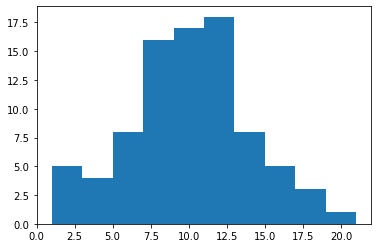

In [71]:
plt.hist(df_4['VenueCategory'])

(array([ 3.,  6., 13., 18., 14., 14.,  5.,  7.,  3.,  2.]),
 array([  563.09 ,  3554.749,  6546.408,  9538.067, 12529.726, 15521.385,
        18513.044, 21504.703, 24496.362, 27488.021, 30479.68 ]),
 <a list of 10 Patch objects>)

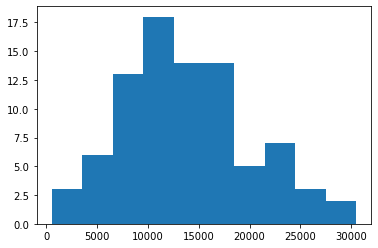

In [72]:
plt.hist(df_4['PopDensity_KM2'])

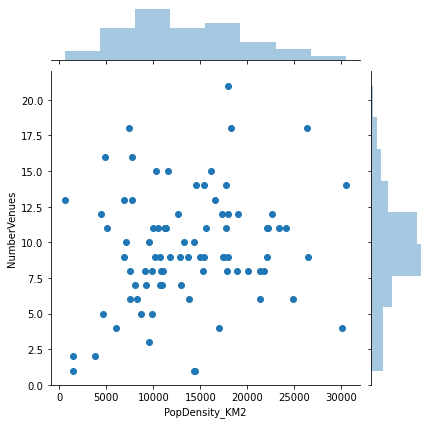

In [23]:
import seaborn as sns 

sns.jointplot(data=df_4, x=df_4['PopDensity_KM2'], y=df_4['NumberVenues']) 


In [80]:
df_4.loc[(df_4['PopDensity_KM2'] >= 20000) & (df_4['NumberVenues'] <= 10)]

,Neighbourhood,lat,lon,NumberVenues,PopDensity_KM2
8,Бибирево,55.907457,37.587854,6,24875.50
25,Коптево,55.839619,37.520107,8,21792.90
33,Люблино,55.686057,37.756972,9,26469.16
37,Митино,55.853075,37.354144,6,21338.54
45,Орехово-Борисово Южное,55.606370,37.708737,4,30056.67
48,Очаково-Матвеевское,55.671870,37.446698,8,21301.87
80,Южное Тушино,55.839948,37.424313,8,20099.28
84,Ясенево,55.593787,37.532633,9,22130.67


In [24]:
# Select the ones you want
df_5 = df_4[['NumberVenues','PopDensity_KM2']]

In [88]:
# Import required packages
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
mms = MinMaxScaler()
mms.fit(df_5)
data_transformed = mms.transform(df_5)

In [89]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

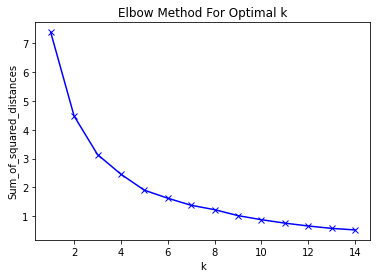

In [90]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [95]:
!pip install yellowbrick

     |████████████████████████████████| 269 kB 12.2 MB/s eta 0:00:01


NameError: name 'cluster_df' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


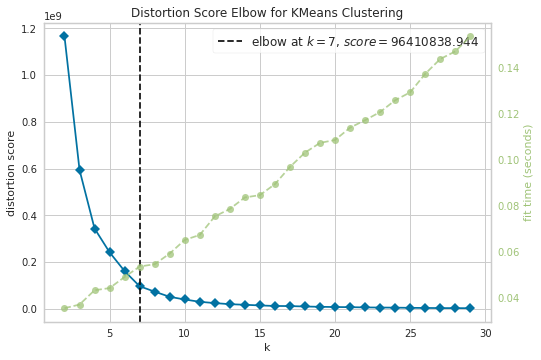

In [96]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(df_5)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

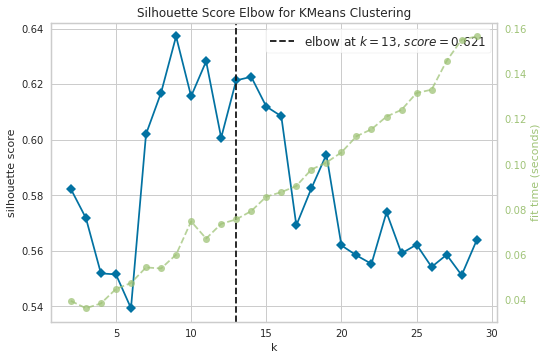

In [97]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(df_5)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

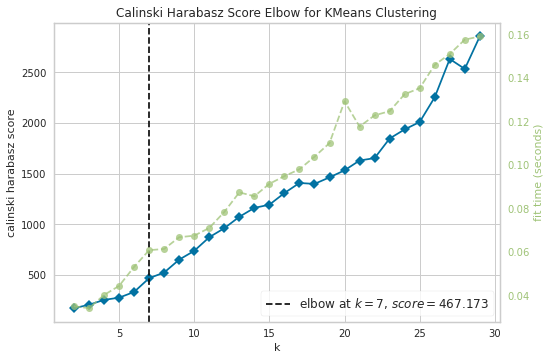

In [98]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(df_5)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [3]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Setting the number of clusters
kclusters = 7
df_clustering = df_4.drop(df_4[["Neighbourhood","lat","lon"]], axis=1)
# Run k-means clustering algorithm
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(df_clustering)
# Checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([0, 6, 0, 0, 0, 6, 5, 3, 3, 2], dtype=int32)

In [4]:
# add clustering labels
df_4.insert(0, 'Cluster Labels', kmeans.labels_)

In [5]:
df_4

,Cluster Labels,Neighbourhood,lat,lon,NumberVenues,PopDensity_KM2
0,0,Академический,55.678645,37.571582,8,18874.44
1,6,Алексеевский,55.814304,37.643488,8,15242.72
2,0,Алтуфьевский,55.874212,37.576297,11,17752.92
3,0,Аэропорт,55.800402,37.533156,9,17367.03
4,0,Бабушкинский,55.880056,37.667719,9,17493.29
...,...,...,...,...,...,...
80,0,Южное Тушино,55.839948,37.424313,8,20099.28
81,0,Южнопортовый,55.728970,37.662553,9,17992.02
82,6,Якиманка,55.740329,37.620661,14,14521.85
83,5,Ярославский,55.879174,37.712051,6,8253.05


In [6]:
df_4['Cluster Labels'].value_counts()

2    20
0    16
6    15
5    12
3    10
1     8
4     4
Name: Cluster Labels, dtype: int64

In [44]:
!pip install seaborn -U

     |████████████████████████████████| 283 kB 10.3 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


In [55]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


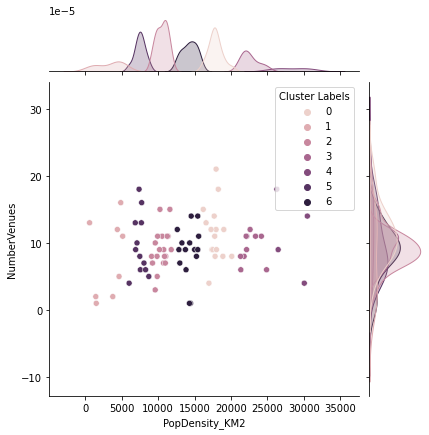

In [7]:
import seaborn as sns 

sns.jointplot(data=df_4, x=df_4['PopDensity_KM2'], y=df_4['NumberVenues'], hue=df_4['Cluster Labels']) 

In [10]:
# create map
latitude = 55.751244
longitude = 37.618423
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, height =600, width = 600)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_4['lat'], df_4['lon'], df_4['NumberVenues'], df_4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results

There are clusters with high, medium and low population density.

# Discussion

There is possibility to use another method of clusterisation as well as adding other features that can be associated with grouping of areas by precense of sport objects in Moscow.

# Conclusion

It is made for the sake of final project of my IBM Data Science Professional Certificate.The research was conducted using many python libraries, IBM Watson Studio, k-means clustering and visualisation. It is possible to add additional relevant information to the research to make it more readable.